In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import folium
from folium import plugins 
from folium.plugins import HeatMap
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [73]:
merged_data = pd.read_csv("/Users/Admin/Desktop/Elon-Musk-Cryptocurrency-Influence/data_processing/merged_data/final_merged_dataset_btc.csv")
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['log_return'] = np.log(merged_data['close'] / merged_data['close'].shift(1))

merged_data = merged_data.dropna()
merged_data.head()

,SENDER,MESSAGE,date,sentiment_score,sentiment,is_crypto_related,symbol,open,high,low,close,log_return
1,-1001153434921,here spec ad cut fun tesla specad elonmusk spa...,2018-09-21 19:00:00,0.300000,Positive,False,BTC/USD,6733.72,6775.34,6726.76,6753.09,0.033388
2,-1001153434921,probably base built elon musk september,2018-09-21 21:00:00,-0.800000,Negative,False,BTC/USD,6708.33,6741.59,6691.28,6713.09,-0.005941
3,-1001153434921,pictwittercomfnhkjduj elon musk september,2018-09-21 21:00:00,0.000000,Neutral,False,BTC/USD,6708.33,6741.59,6691.28,6713.09,0.000000
4,-1001153434921,mar base alpha pictwittercomollqprfy elon musk...,2018-09-21 21:00:00,-0.800000,Negative,False,BTC/USD,6708.33,6741.59,6691.28,6713.09,0.000000
5,-1001153434921,wow thanks offering help coming week incredibl...,2018-09-22 00:00:00,0.133712,Positive,False,BTC/USD,6749.45,6826.28,6745.48,6786.21,0.010833


In [74]:
grouped_data = merged_data.groupby('SENDER')
grouped_data.head()

# Mean Bitcoin before and after
hours_before = 48 
hours_after = 48  

mean_prices = []
dates = []

for sender, data in grouped_data:
    tweet_dates = data['date']
    for tweet_date in tweet_dates:
        start_time = tweet_date - pd.Timedelta(hours=hours_before)
        end_time = tweet_date + pd.Timedelta(hours=hours_after)
        prices_before = data[(data['date'] >= start_time) & (data['date'] < tweet_date)]['close']
        prices_after = data[(data['date'] > tweet_date) & (data['date'] <= end_time)]['close']
        mean_before = prices_before.mean()
        mean_after = prices_after.mean()
        mean_prices.append(mean_after - mean_before)
        dates.append(tweet_date)

# new result df
result_df = pd.DataFrame({'date': dates, 'price_change': mean_prices})

# defining threshold for the price movement
threshold = 2500
significant_changes = result_df[abs(result_df['price_change']) > threshold]

# falls and jumps
price_jumps = significant_changes[significant_changes['price_change'] > 0]
price_falls = significant_changes[significant_changes['price_change'] < 0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=price_jumps['date'], y=price_jumps['price_change'],
                         mode='markers', marker=dict(color='green'), name='Price jump'))
fig.add_trace(go.Scatter(x=price_falls['date'], y=price_falls['price_change'],
                         mode='markers', marker=dict(color='red'), name='Price fall'))
fig.update_layout(title='Bitcoins price movement after Elon Musks Tweets',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Price Movement'))
fig.show()


In [75]:
from math import ceil, sqrt

def movmean(v, kb, kf):
    """
    Computes the mean with a window of length kb+kf+1 that includes the element 
    in the current position, kb elements backward, and kf elements forward.
    Nonexisting elements at the edges get substituted with NaN.
    Args:
        v (list(float)): List of values.
        kb (int): Number of elements to include before current position
        kf (int): Number of elements to include after current position
    Returns:
        list(float): List of the same size as v containing the mean values
    """
    m = len(v) * [np.nan]
    for i in range(kb, len(v)-kf):
        m[i] = np.mean(v[i-kb:i+kf+1])
    return m


def LeeMykland(S, sampling, significance_level=0.1):
    """
    "Jumps in Equilibrium Prices and Market Microstructure Noise"
    - by Suzanne S. Lee and Per A. Mykland
    
    "https://galton.uchicago.edu/~mykland/paperlinks/LeeMykland-2535.pdf"
    
    Args:
        S (list(float)): An array containing prices, where each entry 
                         corresponds to the price sampled every 'sampling' minutes.
        sampling (int): Minutes between entries in S
        significance_level (float): Defaults to 1% (0.001)
        
    Returns:
        A pandas dataframe containing a row covering the interval 
        [t_i, t_i+sampling] containing the following values:
        J:   Binary value is jump with direction (sign)
        L:   L statistics
        T:   Test statistics
        sig: Volatility estimate
    """
    tm = 252*24*60 # Trading minutes
    k   = ceil(sqrt(tm/sampling))
    r = np.append(np.nan, np.diff(np.log(S)))
    bpv = np.multiply(np.absolute(r[:]), np.absolute(np.append(np.nan, r[:-1])))
    bpv = np.append(np.nan, bpv[0:-1]).reshape(-1,1) # Realized bipower variation
    sig = np.sqrt(movmean(bpv, k-3, 0)) # Volatility estimate
    L   = r/sig
    n   = np.size(S) # Length of S
    c   = (2/np.pi)**0.5
    Sn  = c*(2*np.log(n))**0.5
    Cn  = (2*np.log(n))**0.5/c - np.log(np.pi*np.log(n))/(2*c*(2*np.log(n))**0.5)
    beta_star   = -np.log(-np.log(1-significance_level)) # Jump threshold
    T   = (abs(L)-Cn)*Sn
    J   = (T > beta_star).astype(float)
    J   = J*np.sign(r) # Add direction
    # First k rows are NaN involved in bipower variation estimation are set to NaN.
    J[0:k] = np.nan
    # Build and return result dataframe
    return pd.DataFrame({'L': L,'sig': sig, 'T': T,'J':J})


prices = merged_data['open'].tolist()

sampling = 60 

result = LeeMykland(prices, sampling)

merged_data = pd.concat([merged_data, result], axis=1)

merged_data.head()


/var/folders/49/1bqwbw2539j4jwl3zcbb_hb00000gn/T/ipykernel_56798/1813734440.py:48: RuntimeWarning:

invalid value encountered in true_divide



,SENDER,MESSAGE,date,sentiment_score,sentiment,is_crypto_related,symbol,open,high,low,close,log_return,L,sig,T,J
1,-1.001153e+12,here spec ad cut fun tesla specad elonmusk spa...,2018-09-21 19:00:00,0.300000,Positive,False,BTC/USD,6733.72,6775.34,6726.76,6753.09,0.033388,NaN,NaN,NaN,NaN
2,-1.001153e+12,probably base built elon musk september,2018-09-21 21:00:00,-0.800000,Negative,False,BTC/USD,6708.33,6741.59,6691.28,6713.09,-0.005941,NaN,NaN,NaN,NaN
3,-1.001153e+12,pictwittercomfnhkjduj elon musk september,2018-09-21 21:00:00,0.000000,Neutral,False,BTC/USD,6708.33,6741.59,6691.28,6713.09,0.000000,NaN,NaN,NaN,NaN
4,-1.001153e+12,mar base alpha pictwittercomollqprfy elon musk...,2018-09-21 21:00:00,-0.800000,Negative,False,BTC/USD,6708.33,6741.59,6691.28,6713.09,0.000000,NaN,NaN,NaN,NaN
5,-1.001153e+12,wow thanks offering help coming week incredibl...,2018-09-22 00:00:00,0.133712,Positive,False,BTC/USD,6749.45,6826.28,6745.48,6786.21,0.010833,NaN,NaN,NaN,NaN


In [84]:
merged_data.head(555)

,SENDER,MESSAGE,date,sentiment_score,sentiment,is_crypto_related,symbol,open,high,low,close,log_return,L,sig,T,J
1,-1.001153e+12,here spec ad cut fun tesla specad elonmusk spa...,2018-09-21 19:00:00,0.300000,Positive,False,BTC/USD,6733.72,6775.34,6726.76,6753.09,0.033388,NaN,NaN,NaN,NaN
2,-1.001153e+12,probably base built elon musk september,2018-09-21 21:00:00,-0.800000,Negative,False,BTC/USD,6708.33,6741.59,6691.28,6713.09,-0.005941,NaN,NaN,NaN,NaN
3,-1.001153e+12,pictwittercomfnhkjduj elon musk september,2018-09-21 21:00:00,0.000000,Neutral,False,BTC/USD,6708.33,6741.59,6691.28,6713.09,0.000000,NaN,NaN,NaN,NaN
4,-1.001153e+12,mar base alpha pictwittercomollqprfy elon musk...,2018-09-21 21:00:00,-0.800000,Negative,False,BTC/USD,6708.33,6741.59,6691.28,6713.09,0.000000,NaN,NaN,NaN,NaN
5,-1.001153e+12,wow thanks offering help coming week incredibl...,2018-09-22 00:00:00,0.133712,Positive,False,BTC/USD,6749.45,6826.28,6745.48,6786.21,0.010833,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,-1.001153e+12,view spacex dragon berthed last cupola opening...,2019-01-13 18:00:00,0.000000,Neutral,False,BTC/USD,3519.40,3523.96,3499.55,3504.24,0.000000,-0.692420,0.006234,-15.660973,-0.0
552,-1.001153e+12,yet offering mid range model europe elon musk ...,2019-01-13 19:00:00,0.000000,Neutral,False,BTC/USD,3504.24,3515.46,3502.31,3502.81,-0.000408,0.000000,0.006211,-18.121893,0.0
553,-1.001153e+12,falcon land read instruction droneship deliver...,2019-01-13 19:00:00,0.000000,Neutral,False,BTC/USD,3504.24,3515.46,3502.31,3502.81,0.000000,-0.355935,0.006188,-16.856868,-0.0
554,-1.001153e+12,falcon come home pictwittercomvctothsbdn elon ...,2019-01-13 21:00:00,0.000000,Neutral,False,BTC/USD,3496.53,3533.76,3483.75,3511.52,0.002483,0.691791,0.006184,-15.663207,0.0


In [85]:
#filtered_df = merged_data[merged_data['J'] == 1]
filtered_df = merged_data[(merged_data['J'] == -1) | (merged_data['J'] == 1)]

filtered_df.head()

,SENDER,MESSAGE,date,sentiment_score,sentiment,is_crypto_related,symbol,open,high,low,close,log_return,L,sig,T,J
78,-1.001153e+12,perhaps year elon musk november,2018-11-19 15:00:00,0.000000,Neutral,False,BTC/USD,5097.93,5160.99,5071.58,5110.85,0.000000,-6.353986,0.004661,4.460731,-1.0
91,-1.001153e+12,later version elon musk november,2018-11-20 04:00:00,0.000000,Neutral,False,BTC/USD,4802.66,4826.13,4649.02,4650.04,0.000000,-18.274231,0.004589,46.826324,-1.0
100,-1.001153e+12,signing elon musk november,2018-11-22 01:00:00,0.000000,Neutral,False,BTC/USD,4520.01,4589.53,4504.48,4588.44,0.000000,-12.105017,0.005437,24.900398,-1.0
103,-1.001153e+12,here nifty spec sheet pictwittercomaainshsbao ...,2018-11-23 21:00:00,0.000000,Neutral,False,BTC/USD,4213.48,4272.26,4213.48,4260.17,0.011020,-7.389857,0.005437,8.142307,-1.0
116,-1.001153e+12,liter pure water cost elon musk november,2018-11-26 08:00:00,0.214286,Positive,False,BTC/USD,3973.30,3982.53,3855.00,3924.54,-0.012348,-10.070068,0.006229,17.668009,-1.0


In [88]:
#final_df = filtered_df[(filtered_df['is_crypto_related'] == True) & (filtered_df['J'] == 1)]
final_df = filtered_df[(filtered_df['is_crypto_related'] == True)]
final_df.head()

,SENDER,MESSAGE,date,sentiment_score,sentiment,is_crypto_related,symbol,open,high,low,close,log_return,L,sig,T,J
1252,-1.001153e+12,dogecoin rulz pictwittercomflwwugaglu elon mus...,2019-04-02 20:00:00,0.0,Neutral,True,BTC/USD,4759.86,4830.75,4743.85,4802.50,0.000000,31.961572,0.002446,95.472334,1.0
5324,-1.001153e+12,still bitcoins btw elon musk may,2020-05-15 22:00:00,0.0,Neutral,True,BTC/USD,9421.71,9485.28,9332.92,9362.60,0.000000,9.369223,0.003881,15.177146,1.0
7876,-1.001153e+12,frodo underdoge thought would fail pictwitterc...,2021-02-11 09:00:00,-0.5,Negative,True,BTC/USD,45084.64,45623.48,44809.16,45543.51,0.029100,9.505953,0.006115,15.663095,1.0
8525,-1.001153e+12,tesla bitcoin pictwittercomysswjmvzhp elon mus...,2021-05-12 22:00:00,0.0,Neutral,True,BTC/USD,54589.80,54819.00,51576.05,52889.19,0.000000,-10.941977,0.009523,20.766851,-1.0
10289,-1.001153e+12,bitcoin cure cancer elon musk nov,2021-11-20 06:00:00,0.0,Neutral,True,BTC/USD,58463.00,58878.80,58372.53,58719.29,0.002174,6.338581,0.003389,4.405980,1.0


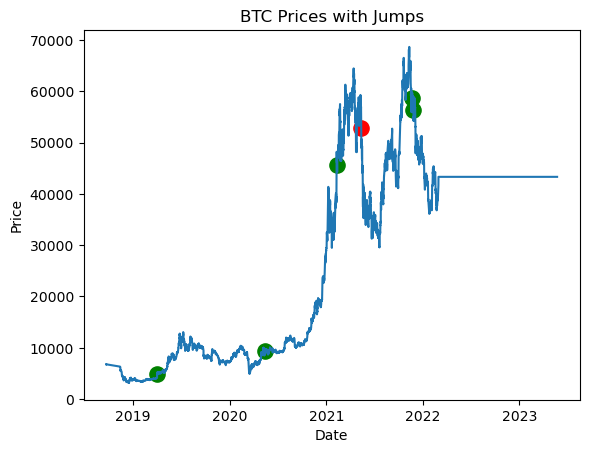

In [105]:
import matplotlib.pyplot as plt

plt.plot(merged_data['date'], merged_data['close'], label='Prices')

jump_indices = final_df[final_df['J'] == 1].index
jump_indices_2 = final_df[final_df['J'] == -1].index
jump_dates = final_df.loc[jump_indices, 'date']
jump_prices = final_df.loc[jump_indices, 'close']
jump_dates_2 = final_df.loc[jump_indices_2, 'date']
jump_prices_2 = final_df.loc[jump_indices_2, 'close']
plt.scatter(jump_dates, jump_prices, color='green', marker='o', s=120, alpha=1, label='Jumps')
plt.scatter(jump_dates_2, jump_prices_2, color='red', marker='o', s=120, alpha=1, label='Jumps')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Prices with Jumps')
plt.show()


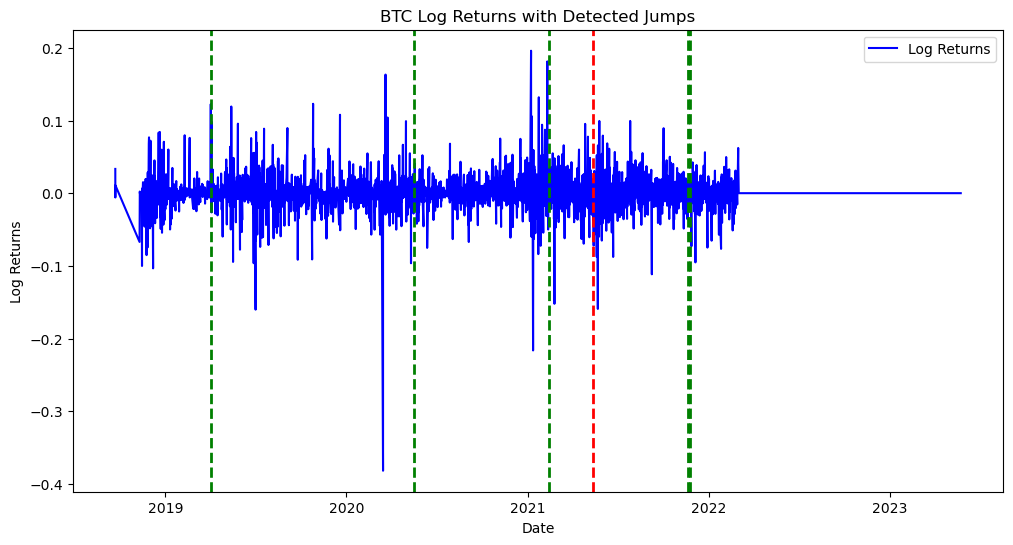

In [180]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged_data_l['date'], merged_data_l['log_return'], color='blue', label='Log Returns')

for index, row in final_df.iterrows():
    if row['J'] == 1:
        plt.axvline(x=row['date'], color='green', linestyle='--', linewidth=2)
    if row['J'] == -1:
        plt.axvline(x=row['date'], color='red', linestyle='--', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('BTC Log Returns with Detected Jumps')

plt.legend()

plt.show()



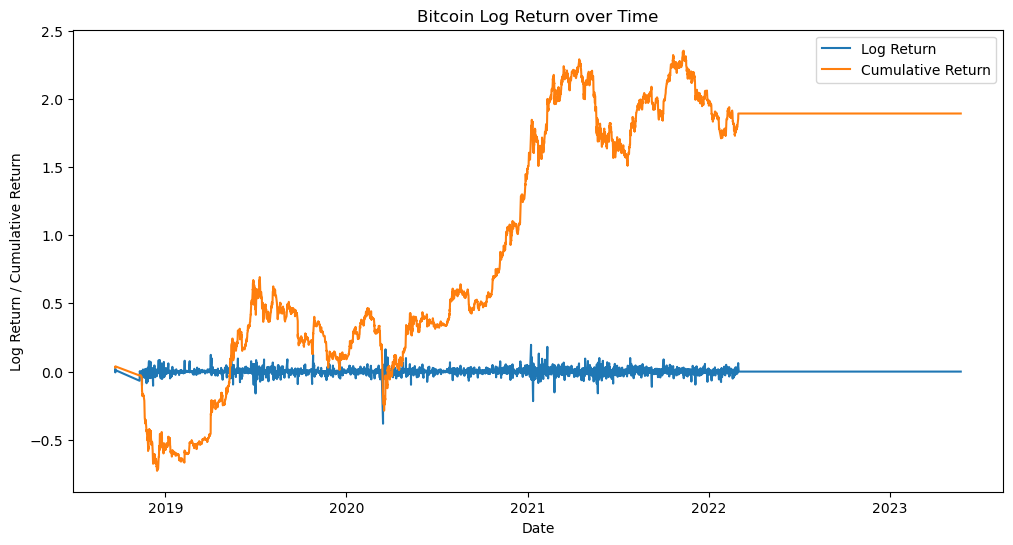

In [94]:
import matplotlib.pyplot as plt

cumulative_returns = merged_data['log_return'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(merged_data['date'], merged_data['log_return'], label='Log Return')
plt.plot(merged_data['date'], cumulative_returns, label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Log Return / Cumulative Return')
plt.title('Bitcoin Log Return over Time')
plt.legend()
plt.show()


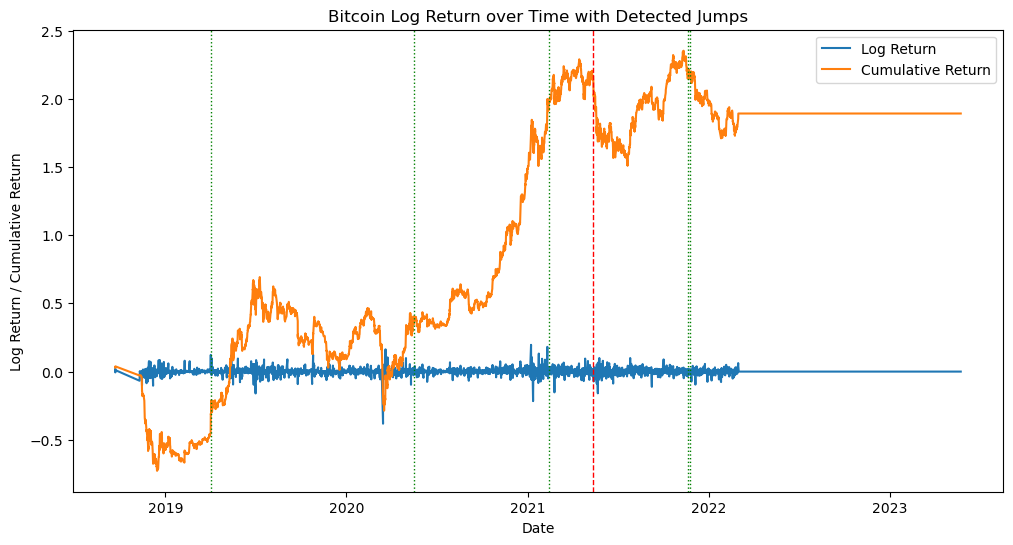

In [187]:
import matplotlib.pyplot as plt

cumulative_returns = merged_data['log_return'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(merged_data['date'], merged_data['log_return'], label='Log Return')
plt.plot(merged_data['date'], cumulative_returns, label='Cumulative Return')
for index, row in final_df.iterrows():
    if row['J'] == 1:
        plt.axvline(x=row['date'], color='green', linestyle='dotted', linewidth=1)
    if row['J'] == -1:
        plt.axvline(x=row['date'], color='red', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Log Return / Cumulative Return')
plt.title('Bitcoin Log Return over Time with Detected Jumps')
plt.legend()
plt.show()


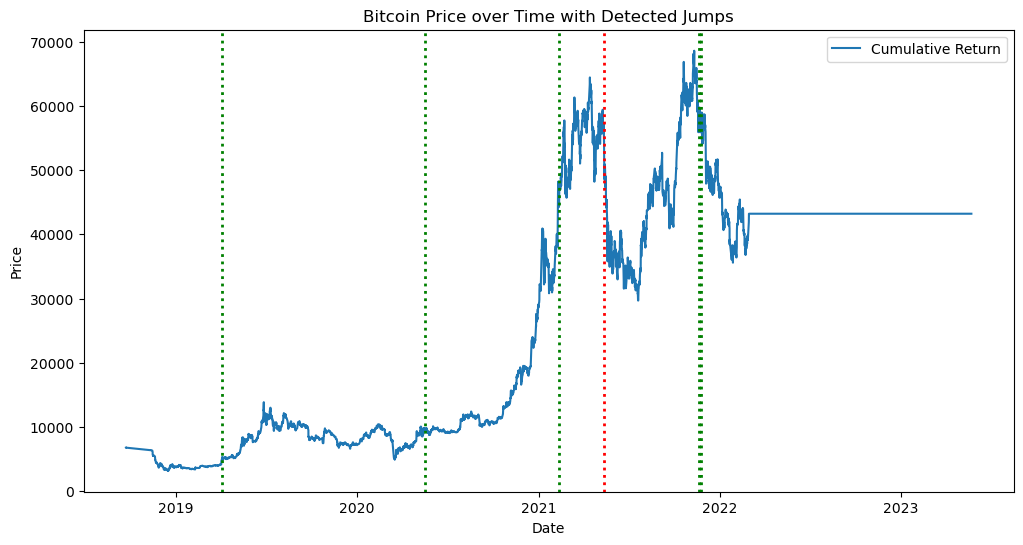

In [185]:
import matplotlib.pyplot as plt

cumulative_returns = merged_data['open']

plt.figure(figsize=(12, 6))
plt.plot(merged_data['date'], cumulative_returns, label='Cumulative Return')
for index, row in final_df.iterrows():
    if row['J'] == 1:
        plt.axvline(x=row['date'], color='green', linestyle='dotted', linewidth=2)
    if row['J'] == -1:
        plt.axvline(x=row['date'], color='red', linestyle='dotted', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price over Time with Detected Jumps')
plt.legend()
plt.show()

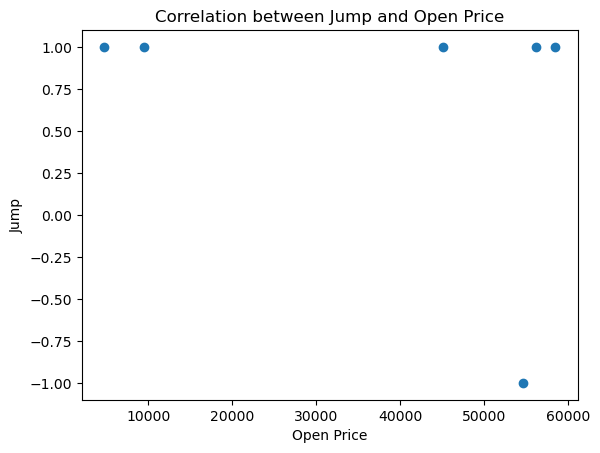

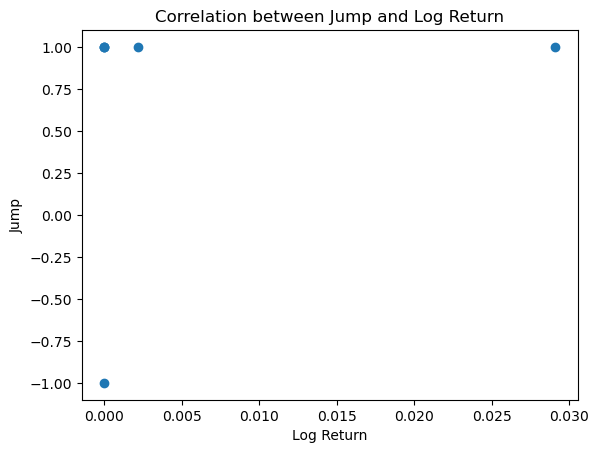

In [117]:
import matplotlib.pyplot as plt

jump_df = final_df[final_df['J'].isin([-1, 1])]

plt.scatter(jump_df['open'], jump_df['J'])
plt.xlabel('Open Price')
plt.ylabel('Jump')
plt.title('Correlation between Jump and Open Price')
plt.show()

plt.scatter(jump_df['log_return'], jump_df['J'])
plt.xlabel('Log Return')
plt.ylabel('Jump')
plt.title('Correlation between Jump and Log Return')
plt.show()


In [173]:
merged_data_d = pd.read_csv("/Users/Admin/Desktop/Elon-Musk-Cryptocurrency-Influence/data_processing/merged_data/final_merged_dataset_dogecoin.csv")
merged_data_d['date'] = pd.to_datetime(merged_data_d['date'])
merged_data_d['log_return'] = np.log(merged_data_d['close'] / merged_data_d['close'].shift(1))

merged_data_d = merged_data_d.dropna()
merged_data_d.head()

,SENDER,MESSAGE,date,is_crypto_related,sentiment_score,sentiment,open,high,low,close,Volume,log_return
1373,-1001153434921,good point elon musk april,2019-04-12 15:00:00,False,0.700000,Positive,0.002802,0.002835,0.002794,0.002798,4.460682e+07,0.0
1374,-1001153434921,lhd order page live within week delivery start...,2019-04-12 15:00:00,False,0.136364,Positive,0.002802,0.002835,0.002794,0.002798,4.460682e+07,0.0
1375,-1001153434921,falcon heavy side booster land landing zone pi...,2019-04-12 15:00:00,False,-0.200000,Negative,0.002802,0.002835,0.002794,0.002798,4.460682e+07,0.0
1376,-1001153434921,liftoff falcon heavy pictwittercomoaljpomba sp...,2019-04-12 15:00:00,False,-0.200000,Negative,0.002802,0.002835,0.002794,0.002798,4.460682e+07,0.0
1377,-1001153434921,leasing available model elon musk april,2019-04-12 15:00:00,False,0.400000,Positive,0.002802,0.002835,0.002794,0.002798,4.460682e+07,0.0


In [174]:
grouped_data = merged_data_d.groupby('SENDER')
grouped_data.head()

# Mean Bitcoin before and after
hours_before = 48 
hours_after = 48  

mean_prices = []
dates = []

for sender, data in grouped_data:
    tweet_dates = data['date']
    for tweet_date in tweet_dates:
        start_time = tweet_date - pd.Timedelta(hours=hours_before)
        end_time = tweet_date + pd.Timedelta(hours=hours_after)
        prices_before = data[(data['date'] >= start_time) & (data['date'] < tweet_date)]['close']
        prices_after = data[(data['date'] > tweet_date) & (data['date'] <= end_time)]['close']
        mean_before = prices_before.mean()
        mean_after = prices_after.mean()
        mean_prices.append(mean_after - mean_before)
        dates.append(tweet_date)

# new result df
result_df = pd.DataFrame({'date': dates, 'price_change': mean_prices})

# defining threshold for the price movement
threshold = 0.0005
significant_changes = result_df[abs(result_df['price_change']) > threshold]

# falls and jumps
price_jumps = significant_changes[significant_changes['price_change'] > 0]
price_falls = significant_changes[significant_changes['price_change'] < 0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=price_jumps['date'], y=price_jumps['price_change'],
                         mode='markers', marker=dict(color='green'), name='Price jump'))
fig.add_trace(go.Scatter(x=price_falls['date'], y=price_falls['price_change'],
                         mode='markers', marker=dict(color='red'), name='Price fall'))
fig.update_layout(title='Bitcoins price movement after Elon Musks Tweets',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Price Movement'))
fig.show()


In [175]:
prices = merged_data_d['open'].tolist()

sampling = 60 

result = LeeMykland(prices, sampling)

merged_data_d = pd.concat([merged_data_d, result], axis=1)

merged_data_d.head()


/var/folders/49/1bqwbw2539j4jwl3zcbb_hb00000gn/T/ipykernel_56798/1813734440.py:48: RuntimeWarning:

invalid value encountered in true_divide



,SENDER,MESSAGE,date,is_crypto_related,sentiment_score,sentiment,open,high,low,close,Volume,log_return,L,sig,T,J
1373,-1.001153e+12,good point elon musk april,2019-04-12 15:00:00,False,0.700000,Positive,0.002802,0.002835,0.002794,0.002798,4.460682e+07,0.0,2.770392,0.004558,-8.174147,0.0
1374,-1.001153e+12,lhd order page live within week delivery start...,2019-04-12 15:00:00,False,0.136364,Positive,0.002802,0.002835,0.002794,0.002798,4.460682e+07,0.0,0.276670,0.004730,-17.005772,0.0
1375,-1.001153e+12,falcon heavy side booster land landing zone pi...,2019-04-12 15:00:00,False,-0.200000,Negative,0.002802,0.002835,0.002794,0.002798,4.460682e+07,0.0,-0.305950,0.004752,-16.902075,-0.0
1376,-1.001153e+12,liftoff falcon heavy pictwittercomoaljpomba sp...,2019-04-12 15:00:00,False,-0.200000,Negative,0.002802,0.002835,0.002794,0.002798,4.460682e+07,0.0,-2.230307,0.004755,-10.086882,-0.0
1377,-1.001153e+12,leasing available model elon musk april,2019-04-12 15:00:00,False,0.400000,Positive,0.002802,0.002835,0.002794,0.002798,4.460682e+07,0.0,0.092346,0.004776,-17.658563,0.0


In [176]:
#filtered_df = merged_data[merged_data['J'] == 1]
filtered_df_d = merged_data_d[(merged_data_d['J'] == -1) | (merged_data_d['J'] == 1)]

filtered_df_d.head()

,SENDER,MESSAGE,date,is_crypto_related,sentiment_score,sentiment,open,high,low,close,Volume,log_return,L,sig,T,J
1390,-1.001153e+12,april investor autonomy day tesla free investo...,2019-04-13 16:00:00,False,0.4,Positive,0.002823,0.002823,0.002774,0.002795,9.488618e+07,0.000000,-8.184454,0.004838,10.999984,-1.0
1393,-1.001153e+12,tesla start fsd computer upgrade month elon mu...,2019-04-13 17:00:00,False,0.0,Neutral,0.002798,0.002813,0.002780,0.002809,2.019941e+07,0.004996,5.736661,0.005151,2.331023,1.0
1438,-1.001153e+12,thinking adding giant stainless steel dragon w...,2019-04-14 23:00:00,False,0.1,Positive,0.002851,0.002855,0.002829,0.002849,1.234555e+07,0.000000,-6.089193,0.004914,3.579528,-1.0
1461,-1.001153e+12,kettleman city supercharger station stall kw s...,2019-04-17 17:00:00,False,0.0,Neutral,0.002754,0.002763,0.002751,0.002756,1.464636e+06,-0.001813,8.498814,0.004791,12.113306,1.0
1490,-1.001153e+12,love castle elon musk april,2019-04-19 18:00:00,False,0.5,Positive,0.002842,0.002859,0.002842,0.002857,1.471003e+06,0.005968,-7.366351,0.004499,8.102638,-1.0


In [178]:
#final_df = filtered_df[(filtered_df['is_crypto_related'] == True) & (filtered_df['J'] == 1)]
final_df_d = filtered_df_d[(filtered_df_d['is_crypto_related'] == True)]
final_df_d.head()

,SENDER,MESSAGE,date,is_crypto_related,sentiment_score,sentiment,open,high,low,close,Volume,log_return,L,sig,T,J
4390,-1.001153e+12,market bit high anyway due correction elon mus...,2020-03-09 20:00:00,True,0.017500,Positive,0.002178,0.002184,0.002163,0.002165,3.439434e+06,0.000000,-7.202364,0.001483,7.521872,-1.0
7439,-1.001153e+12,one word doge elon musk december,2020-12-20 10:00:00,True,0.000000,Neutral,0.004634,0.004767,0.004289,0.004353,2.346055e+09,0.000000,-7.255926,0.015679,7.711564,-1.0
7839,-1.001153e+12,let doge elon musk february,2021-02-07 22:00:00,True,0.000000,Neutral,0.077326,0.087297,0.076862,0.081197,5.095936e+09,0.000000,-6.340364,0.006092,4.469062,-1.0
7994,-1.001153e+12,doge meme shield legendary item pictwittercomc...,2021-03-01 20:00:00,True,1.000000,Positive,0.051757,0.051882,0.049612,0.050144,6.799872e+08,-0.032828,25.336721,0.004944,71.745477,1.0
8551,-1.001153e+12,bitcoin actually highly centralized supermajor...,2021-05-16 18:00:00,True,0.122143,Positive,0.523635,0.524840,0.504700,0.509807,3.798450e+08,0.000000,-5.910446,0.004414,2.946488,-1.0


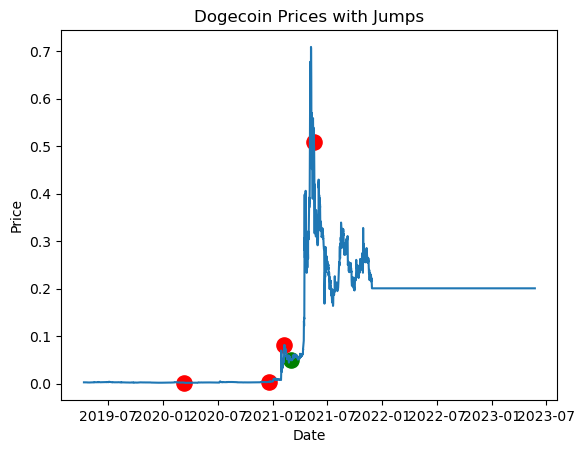

In [179]:
import matplotlib.pyplot as plt

plt.plot(merged_data_d['date'], merged_data_d['close'], label='Prices')

jump_indices_d = final_df_d[final_df_d['J'] == 1].index
jump_indices_2_d = final_df_d[final_df_d['J'] == -1].index
jump_dates_d = final_df_d.loc[jump_indices_d, 'date']
jump_prices_d = final_df_d.loc[jump_indices_d, 'close']
jump_dates_2_d = final_df_d.loc[jump_indices_2_d, 'date']
jump_prices_2_d = final_df_d.loc[jump_indices_2_d, 'close']
plt.scatter(jump_dates_d, jump_prices_d, color='green', marker='o', s=120, alpha=1, label='Jumps')
plt.scatter(jump_dates_2_d, jump_prices_2_d, color='red', marker='o', s=120, alpha=1, label='Jumps')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Dogecoin Prices with Jumps')
plt.show()


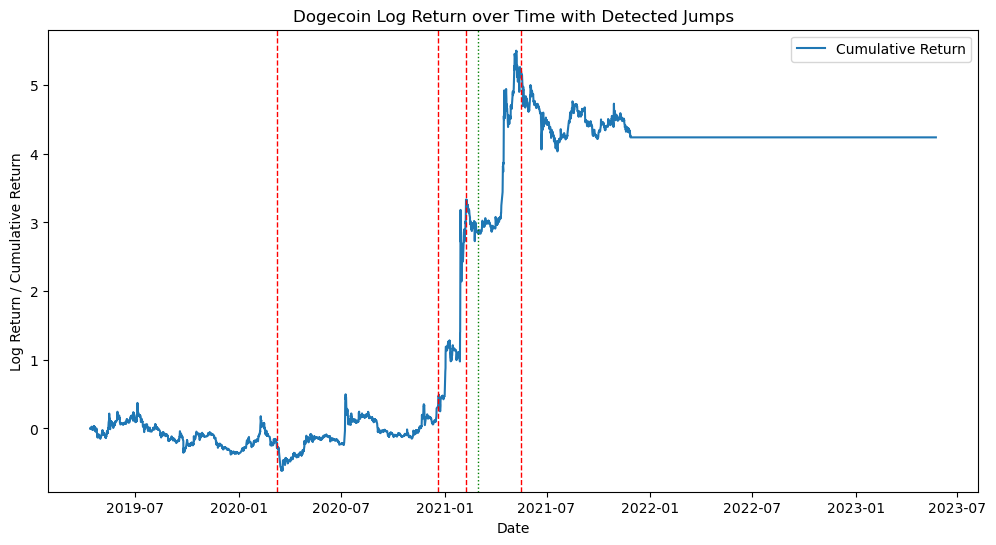

In [184]:
import matplotlib.pyplot as plt

cumulative_returns_d = merged_data_d['log_return'].cumsum()

plt.figure(figsize=(12, 6))
#plt.plot(merged_data_d['date'], merged_data_d['log_return'], label='Log Return')
plt.plot(merged_data_d['date'], cumulative_returns_d, label='Cumulative Return')
for index, row in final_df_d.iterrows():
    if row['J'] == 1:
        plt.axvline(x=row['date'], color='green', linestyle='dotted', linewidth=1)
    if row['J'] == -1:
        plt.axvline(x=row['date'], color='red', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Log Return / Cumulative Return')
plt.title('Dogecoin Log Return over Time with Detected Jumps')
plt.legend()
plt.show()



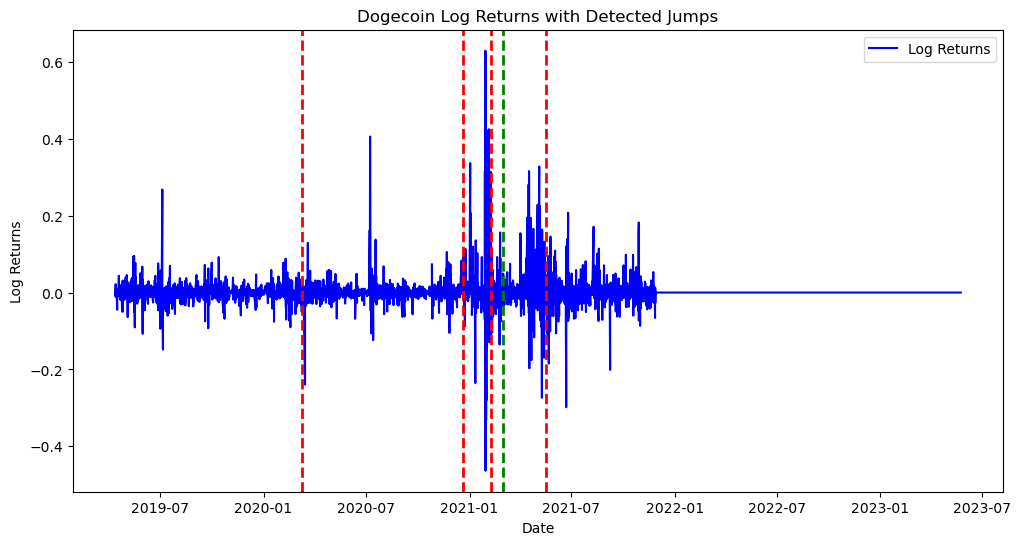

In [188]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged_data_d['date'], merged_data_d['log_return'], color='blue', label='Log Returns')

for index, row in final_df_d.iterrows():
    if row['J'] == 1:
        plt.axvline(x=row['date'], color='green', linestyle='--', linewidth=2)
    if row['J'] == -1:
        plt.axvline(x=row['date'], color='red', linestyle='--', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Dogecoin Log Returns with Detected Jumps')

plt.legend()

plt.show()


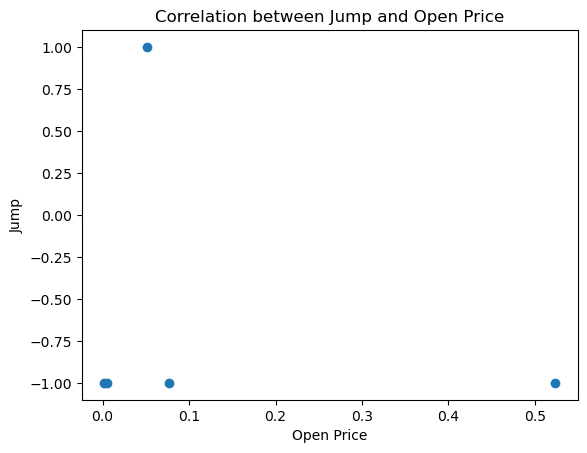

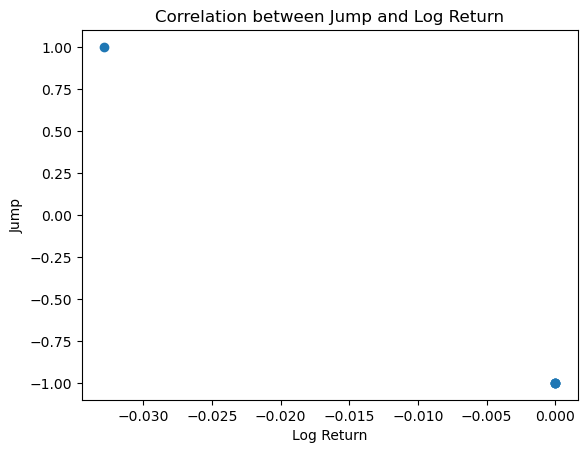

In [186]:
import matplotlib.pyplot as plt

jump_df_d = final_df_d[final_df_d['J'].isin([-1, 1])]

plt.scatter(jump_df_d['open'], jump_df_d['J'])
plt.xlabel('Open Price')
plt.ylabel('Jump')
plt.title('Correlation between Jump and Open Price')
plt.show()

plt.scatter(jump_df_d['log_return'], jump_df_d['J'])
plt.xlabel('Log Return')
plt.ylabel('Jump')
plt.title('Correlation between Jump and Log Return')
plt.show()
